In [98]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, roc_auc_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.tree import DecisionTreeClassifier, export_graphviz, export_text
from sklearn.ensemble import RandomForestClassifier
import graphviz
import xgboost as xgb
%matplotlib inline

# 1. Подготовка датасета

#### Описание датасета
- status — удалось ли клиенту погасить кредит (1) или нет (2);
- seniority — стаж работы в годах;
- home — тип домовладения: аренда (1), владение (2) и другие;
- time — планируемый срок предоставления кредита (в месяцах);
- age — возраст клиента;
- marital[status] — холост (1), женат (2) и др.;
- records — есть ли у клиента какие-либо предыдущие записи: нет (1), да (2) (из описания набора данных неясно, о каких записях здесь идет речь. Можно предположить, что речь о записях в базе данных банка);
- job — тип работы: полный рабочий день (1), неполный рабочий день (2) и другие;
- expenses — сколько клиент тратит в месяц;
- income — сколько клиент зарабатывает в месяц;
- assets — общая стоимость всех активов клиента;
- debt — сумма кредитной задолженности;
- amount — запрашиваемая сумма кредита;
- price — цена товара, который клиент хочет приобрести.

#### Считаем данные

In [99]:
df = pd.read_csv('CreditScoring.csv')

In [100]:
df.head()

,Status,Seniority,Home,Time,Age,Marital,Records,Job,Expenses,Income,Assets,Debt,Amount,Price
0,1,9,1,60,30,2,1,3,73,129,0,0,800,846
1,1,17,1,60,58,3,1,1,48,131,0,0,1000,1658
2,2,10,2,36,46,2,2,3,90,200,3000,0,2000,2985
3,1,0,1,60,24,1,1,1,63,182,2500,0,900,1325
4,1,0,1,36,26,1,1,1,46,107,0,0,310,910


#### Приведём названия столбцов к нижнему регистру

In [101]:
df.columns = df.columns.str.lower()
df.head()

,status,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
0,1,9,1,60,30,2,1,3,73,129,0,0,800,846
1,1,17,1,60,58,3,1,1,48,131,0,0,1000,1658
2,2,10,2,36,46,2,2,3,90,200,3000,0,2000,2985
3,1,0,1,60,24,1,1,1,63,182,2500,0,900,1325
4,1,0,1,36,26,1,1,1,46,107,0,0,310,910


#### Выведем информацию о датасете
Хотя большинство столбцов числовые, мы видим и категориальные: status, home, marital[status], records и job. Однако значения, которые мы наблюдаем в датафрейме, являются числами, а не строками. Нам нужно привести их к их настоящим именам.

In [102]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4455 entries, 0 to 4454
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   status     4455 non-null   int64
 1   seniority  4455 non-null   int64
 2   home       4455 non-null   int64
 3   time       4455 non-null   int64
 4   age        4455 non-null   int64
 5   marital    4455 non-null   int64
 6   records    4455 non-null   int64
 7   job        4455 non-null   int64
 8   expenses   4455 non-null   int64
 9   income     4455 non-null   int64
 10  assets     4455 non-null   int64
 11  debt       4455 non-null   int64
 12  amount     4455 non-null   int64
 13  price      4455 non-null   int64
dtypes: int64(14)
memory usage: 487.4 KB


#### Декодируем числа по категориям.
Мы начнем со столбца status. Значение 1 означает ОК‚ 2 означает default, а 0 означает, что значение отсутствует, — заменим его на unk (сокращение для unknown).

In [103]:
status_values = {
    1:'ok',
    2:'default',
    0:'unk'
}

df.status = df.status.map(status_values)
df.head()

,status,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
0,ok,9,1,60,30,2,1,3,73,129,0,0,800,846
1,ok,17,1,60,58,3,1,1,48,131,0,0,1000,1658
2,default,10,2,36,46,2,2,3,90,200,3000,0,2000,2985
3,ok,0,1,60,24,1,1,1,63,182,2500,0,900,1325
4,ok,0,1,36,26,1,1,1,46,107,0,0,310,910


#### Повторим ту же процедуру для всех остальных столбцов.


In [104]:
home_values = {
    1:'rent',
    2:'owner',
    3:'private',
    4:'ignore',
    5:'parents',
    6:'other',
    0:'unk'
}

df.home = df.home.map(home_values)

In [105]:
marital_values = {
    1:'single',
    2:'married',
    3:'widow',
    4:'separated',
    5:'divorced',
    0:'unk'
}

df.marital = df.marital.map(marital_values)

In [106]:
records_values = {
    1:'no',
    2:'yes',
    0:'unk'
}

df.records = df.records.map(records_values)

In [107]:
job_values = {
    1:'fixed',
    2:'partime',
    3:'freelance',
    4:'others',
    0:'unk'
}

df.job = df.job.map(job_values)

In [108]:
df.head()

,status,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
0,ok,9,rent,60,30,married,no,freelance,73,129,0,0,800,846
1,ok,17,rent,60,58,widow,no,fixed,48,131,0,0,1000,1658
2,default,10,owner,36,46,married,yes,freelance,90,200,3000,0,2000,2985
3,ok,0,rent,60,24,single,no,fixed,63,182,2500,0,900,1325
4,ok,0,rent,36,26,single,no,fixed,46,107,0,0,310,910


#### Выведем основные статистические показатели
Замечаем, что в некоторых случаях максимальное значение равно 99999999. Это довольно подозрительно. Как оказалось, это искусственное значение — именно так кодируются недостающие значения в этом наборе данных.

In [109]:
df.describe().round(2)

,seniority,time,age,expenses,income,assets,debt,amount,price
count,4455.00,4455.00,4455.00,4455.00,4455.00,4455.00,4455.00,4455.00,4455.00
mean,7.99,46.44,37.08,55.57,763316.99,1060340.81,404381.96,1039.02,1462.88
std,8.17,14.66,10.98,19.52,8703625.26,10217568.67,6344253.40,474.54,628.09
min,0.00,6.00,18.00,35.00,0.00,0.00,0.00,100.00,105.00
25%,2.00,36.00,28.00,35.00,80.00,0.00,0.00,700.00,1117.50
50%,5.00,48.00,36.00,51.00,120.00,3500.00,0.00,1000.00,1400.00
75%,12.00,60.00,45.00,72.00,166.00,6000.00,0.00,1300.00,1692.00
max,48.00,72.00,68.00,180.00,99999999.00,99999999.00,99999999.00,5000.00,11140.00


#### Эта проблема наблюдается в трех столбцах: income, assets и debt. Заменим для них это большое число на NaN:


In [110]:
for c in ['income', 'assets', 'debt']:
    df[c] = df[c].replace(to_replace = 99999999, value=np.nan)

In [111]:
df.describe().round(2)

,seniority,time,age,expenses,income,assets,debt,amount,price
count,4455.00,4455.00,4455.00,4455.00,4421.00,4408.00,4437.00,4455.00,4455.00
mean,7.99,46.44,37.08,55.57,130.57,5403.43,342.95,1039.02,1462.88
std,8.17,14.66,10.98,19.52,86.37,11573.16,1245.86,474.54,628.09
min,0.00,6.00,18.00,35.00,0.00,0.00,0.00,100.00,105.00
25%,2.00,36.00,28.00,35.00,80.00,0.00,0.00,700.00,1117.50
50%,5.00,48.00,36.00,51.00,120.00,3000.00,0.00,1000.00,1400.00
75%,12.00,60.00,45.00,72.00,165.00,6000.00,0.00,1300.00,1692.00
max,48.00,72.00,68.00,180.00,959.00,300000.00,30000.00,5000.00,11140.00


#### Посмотрим количество пропущенных значений

In [112]:
df.isnull().sum()

status        0
seniority     0
home          0
time          0
age           0
marital       0
records       0
job           0
expenses      0
income       34
assets       47
debt         18
amount        0
price         0
dtype: int64

#### Прежде чем закончить подготовку набора данных, посмотрим на нашу целевую переменную status
Обратим внимание, что имеется одна строка со статусом unknown: мы не знаем, удалось ли этому клиенту погасить кредит. Для нашего проекта она бесполезна, поэтому сразу удалим ее из набора данных


In [113]:
df.status.value_counts()

status
ok         3200
default    1254
unk           1
Name: count, dtype: int64

In [114]:
df = df[df.status != 'unk']

# 2. Подготовка набора данных

#### Разделим набор данных на обучающую, проверочную и тестовую выборку;

In [115]:
df_train_full, df_test = train_test_split(df, test_size=0.2, random_state=42)
df_train, df_val = train_test_split(df_train_full, test_size=0.25, random_state=11)

In [116]:
len(df_train), len(df_val), len(df_test)

(2672, 891, 891)

In [117]:
y_train = (df_train.status == 'default').values
y_val = (df_val.status == 'default').values
y_test = (df_test.status == 'default').values

In [118]:
del df_train['status']
del df_val['status']
del df_test['status']

#### Далее мы позаботимся о X — матрице признаков.
Из первоначального анализа мы знаем, что наши данные содержат недостающие значения — мы добавляли эти NaN самостоятельно. Мы
можем заменить недостающие значения нулями

In [119]:
df_train = df_train.fillna(0)
df_val = df_val.fillna(0)
df_test = df_test.fillna(0)

#### Векторизуем данные с помощью DictVectorizer

In [120]:
dict_train = df_train.to_dict(orient='records')
dict_val = df_val.to_dict(orient='records')
dict_test = df_test.to_dict(orient='records')
dict_train[0]

{'seniority': 1,
 'home': 'parents',
 'time': 48,
 'age': 26,
 'marital': 'single',
 'records': 'no',
 'job': 'freelance',
 'expenses': 35,
 'income': 500.0,
 'assets': 0.0,
 'debt': 0.0,
 'amount': 1300,
 'price': 1561}

#### Полученный список словарей теперь можно использовать в качестве входных данных для DictVectorizer:

In [121]:
dv = DictVectorizer(sparse=False)
dv.fit(dict_train)

X_train = dv.transform(dict_train)
X_val = dv.transform(dict_val)
X_test = dv.transform(dict_test)

# 3. Обучение дерева решений

In [122]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

DecisionTreeClassifier()

#### Оценим качество обучения

In [123]:
y_pred = dt.predict_proba(X_train)[:, 1]
roc_auc_score(y_train, y_pred)

0.9999996479071601

In [124]:
y_pred = dt.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred)

0.6707033465683494

#### Поставим ограничение роста дерева в глубину

In [125]:
dt = DecisionTreeClassifier(max_depth=2)
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=2)

In [126]:
tree_text = export_text(dt, feature_names=dv.feature_names_)
print(tree_text)

|--- seniority <= 2.50
|   |--- job=fixed <= 0.50
|   |   |--- class: True
|   |--- job=fixed >  0.50
|   |   |--- class: False
|--- seniority >  2.50
|   |--- records=yes <= 0.50
|   |   |--- class: False
|   |--- records=yes >  0.50
|   |   |--- class: False



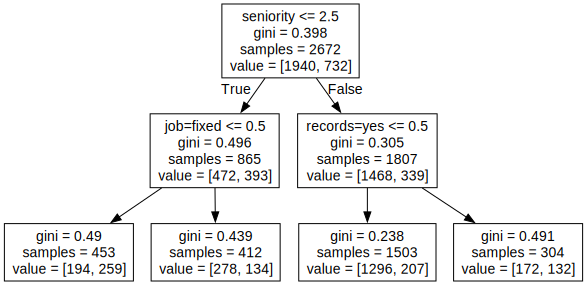

In [127]:
graph = export_graphviz(dt,feature_names=dv.feature_names_)
graph = graphviz.Source(graph, format="png") 
graph

#### Проверим метрику

In [128]:
y_pred = dt.predict_proba(X_train)[:, 1]
roc_auc_score(y_train, y_pred)

0.7202995605881359

In [129]:
y_pred = dt.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred)

0.7105628033024516

#### Пробуем перебором найти оптимальную глубину дерева

In [130]:
for depth in [1, 2, 3, 4, 5, 6, 10, 15, 20, None]:
    dt = DecisionTreeClassifier(max_depth=depth)

    dt.fit(X_train, y_train)
    y_pred = dt.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)
    print('%s -> %.3f' % (depth, auc))

1 -> 0.646
2 -> 0.711
3 -> 0.773
4 -> 0.788
5 -> 0.787
6 -> 0.788
10 -> 0.686
15 -> 0.670
20 -> 0.667
None -> 0.678


#### Пробуем перебором найти оптимальное количество листьев

In [131]:
for m in [4, 5, 6]:
    print('depth: %s' %m)

    for s in [1, 5, 10, 15, 20, 50, 100, 200]:
        dt = DecisionTreeClassifier(max_depth=m, min_samples_leaf=s)
        dt.fit(X_train, y_train)
        y_pred = dt.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)
        print('%s -> %.3f' % (s, auc))

depth: 4
1 -> 0.790
5 -> 0.788
10 -> 0.790
15 -> 0.789
20 -> 0.794
50 -> 0.798
100 -> 0.768
200 -> 0.751
depth: 5
1 -> 0.787
5 -> 0.787
10 -> 0.795
15 -> 0.789
20 -> 0.800
50 -> 0.814
100 -> 0.774
200 -> 0.754
depth: 6
1 -> 0.795
5 -> 0.810
10 -> 0.817
15 -> 0.815
20 -> 0.821
50 -> 0.823
100 -> 0.775
200 -> 0.756


#### Мы обнаружили наши наилучшие параметры (min_sample_leaf=50 и max_depth=6 ), поэтому используем их для обучения окончательной модели дерева решений:

In [132]:
dt = DecisionTreeClassifier(max_depth=6, min_samples_leaf=50)
dt.fit(X_train, y_train)

y_pred_dt = dt.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred_dt)

0.8233850129198965

# 4. Обучение случайного леса

In [133]:
rf = RandomForestClassifier(n_estimators=10, random_state=23)
rf.fit(X_train, y_train)

y_pred = rf.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred)

0.8036711413625763

#### Чтобы понять, сколько деревьев нам требуется, мы можем перебрать различные значения для n_estimators и оценить его влияние на AUC:


10 -> 0.80367
20 -> 0.82387
30 -> 0.83322
40 -> 0.83414
50 -> 0.83414
60 -> 0.83688
70 -> 0.83705
80 -> 0.84077
90 -> 0.84015
100 -> 0.83991
110 -> 0.84085
120 -> 0.84234
130 -> 0.84213
140 -> 0.84153
150 -> 0.84158
160 -> 0.84140
170 -> 0.84057
180 -> 0.84118
190 -> 0.84121
200 -> 0.84135


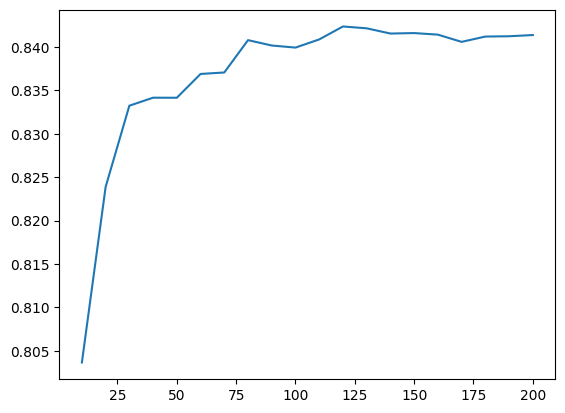

In [134]:
aucs = []

for i in range(10, 201, 10):
    rf = RandomForestClassifier(n_estimators=i, random_state=23)
    rf.fit(X_train, y_train)
    
    y_pred = rf.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)
    print('%s -> %.5f' % (i, auc))

    aucs.append(auc)

plt.plot(range(10, 201, 10), aucs)

#### Пробуем перебором найти оптимальную глубину для RF

depth: 5
10 -> 0.820
20 -> 0.834
30 -> 0.839
40 -> 0.840
50 -> 0.839
60 -> 0.841
70 -> 0.840
80 -> 0.841
90 -> 0.841
100 -> 0.841
110 -> 0.842
120 -> 0.842
130 -> 0.842
140 -> 0.841
150 -> 0.841
160 -> 0.841
170 -> 0.841
180 -> 0.841
190 -> 0.841
200 -> 0.841

depth: 10
10 -> 0.815
20 -> 0.834
30 -> 0.839
40 -> 0.840
50 -> 0.839
60 -> 0.841
70 -> 0.842
80 -> 0.844
90 -> 0.843
100 -> 0.845
110 -> 0.846
120 -> 0.847
130 -> 0.847
140 -> 0.847
150 -> 0.848
160 -> 0.848
170 -> 0.849
180 -> 0.849
190 -> 0.848
200 -> 0.848

depth: 20
10 -> 0.809
20 -> 0.828
30 -> 0.836
40 -> 0.838
50 -> 0.837
60 -> 0.842
70 -> 0.840
80 -> 0.844
90 -> 0.845
100 -> 0.843
110 -> 0.842
120 -> 0.842
130 -> 0.843
140 -> 0.842
150 -> 0.842
160 -> 0.841
170 -> 0.841
180 -> 0.843
190 -> 0.842
200 -> 0.843



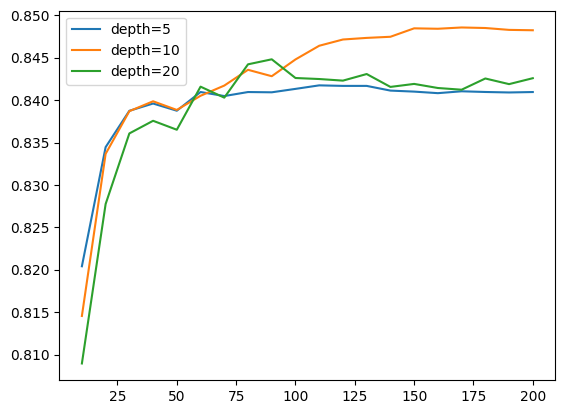

In [135]:
all_aucs = {}

for depth in [5, 10, 20]:
    
    print('depth: %s' % depth)
    aucs = []
    
    for i in range(10, 201, 10):
        rf = RandomForestClassifier(n_estimators=i, max_depth=depth, random_state=23)
        rf.fit(X_train, y_train)
        
        y_pred = rf.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)
        print('%s -> %.3f' % (i, auc))
        aucs.append(auc)

    all_aucs[depth] = aucs
    print()
    
num_trees = list(range(10, 201, 10))
plt.plot(num_trees, all_aucs[5], label='depth=5')
plt.plot(num_trees, all_aucs[10], label='depth=10')
plt.plot(num_trees, all_aucs[20], label='depth=20')
plt.legend()

#### Пробуем перебором найти оптимальное количество листьев для RF

min_samples_leaf: 3
10 -> 0.833
20 -> 0.843
30 -> 0.842
40 -> 0.847
50 -> 0.849
60 -> 0.849
70 -> 0.849
80 -> 0.849
90 -> 0.849
100 -> 0.849
110 -> 0.849
120 -> 0.849
130 -> 0.849
140 -> 0.849
150 -> 0.849
160 -> 0.849
170 -> 0.850
180 -> 0.850
190 -> 0.850
200 -> 0.850

min_samples_leaf: 5
10 -> 0.833
20 -> 0.839
30 -> 0.844
40 -> 0.846
50 -> 0.848
60 -> 0.847
70 -> 0.849
80 -> 0.850
90 -> 0.849
100 -> 0.849
110 -> 0.849
120 -> 0.849
130 -> 0.850
140 -> 0.849
150 -> 0.850
160 -> 0.850
170 -> 0.849
180 -> 0.850
190 -> 0.850
200 -> 0.850

min_samples_leaf: 10
10 -> 0.841
20 -> 0.851
30 -> 0.851
40 -> 0.852
50 -> 0.852
60 -> 0.852
70 -> 0.852
80 -> 0.852
90 -> 0.852
100 -> 0.852
110 -> 0.852
120 -> 0.852
130 -> 0.853
140 -> 0.853
150 -> 0.853
160 -> 0.853
170 -> 0.853
180 -> 0.853
190 -> 0.853
200 -> 0.853



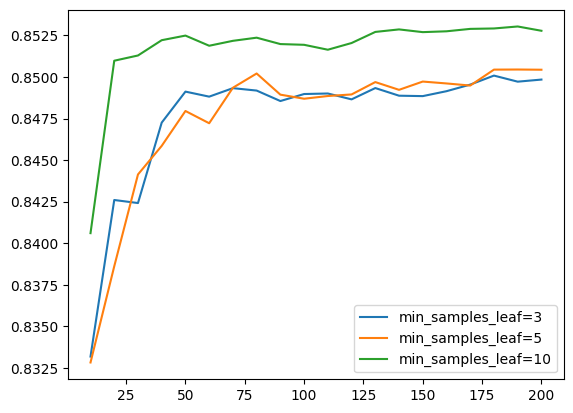

In [136]:
all_aucs = {}

for m in [3, 5, 10]:
    
    print('min_samples_leaf: %s' % m)
    aucs = []
    
    for i in range(10, 201, 10):
        rf = RandomForestClassifier(n_estimators=i, max_depth=10, \
                                    min_samples_leaf=m, random_state=23)
        rf.fit(X_train, y_train)
        
        y_pred = rf.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)
        print('%s -> %.3f' % (i, auc))
        aucs.append(auc)

    all_aucs[m] = aucs
    print()
    
num_trees = list(range(10, 201, 10))
plt.plot(num_trees, all_aucs[3], label='min_samples_leaf=3')
plt.plot(num_trees, all_aucs[5], label='min_samples_leaf=5')
plt.plot(num_trees, all_aucs[10], label='min_samples_leaf=10')
plt.legend()

#### Мы достигли наилучшего AUC с 135 деревьями, поэтому следует установить параметр n_estimators = 135.

- количество деревьев n_estimators = 135
- глубина деревьев max_depth = 10
- число образцов в группе min_samples_leaf = 10

#### Обучим итоговую модель

In [137]:
rf = RandomForestClassifier(n_estimators=135, max_depth=10, min_samples_leaf=10, random_state=23)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict_proba(X_val)[:, 1]
auc = roc_auc_score(y_val, y_pred_rf)
print('%.3f' % auc)

0.853


# 5. Градиентный бустинг

#### Прежде чем мы сможем обучить модель XGBoost, нам нужно обернуть наши данные в DMatrix — специальную структуру данных для эффективного поиска разбиений:

In [138]:
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=dv.feature_names_)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=dv.feature_names_)
dtest = xgb.DMatrix(X_test, label=y_test, feature_names=dv.feature_names_)

#### Укажем параметры

In [162]:
xgb_params = {
    'eta': 0.3,
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 4,
    'seed': 23
}

In [163]:
model = xgb.train(xgb_params, dtrain, num_boost_round=10)

In [164]:
y_pred = model.predict(dval)
y_pred[:10]

array([0.12300754, 0.3273528 , 0.04703829, 0.33858016, 0.10216632,
       0.04355047, 0.42210156, 0.465147  , 0.11104547, 0.88539034],
      dtype=float32)

In [165]:
roc_auc_score(y_val, y_pred)

0.8456797126110795

#### Мониторинг производительности модели

In [166]:
watchlist = [(dtrain, 'train'), (dval, 'val')]

In [167]:
model = xgb.train(xgb_params, dtrain, num_boost_round=100, \
                 evals=watchlist, verbose_eval=10)

[0]	train-auc:0.84831	val-auc:0.81043
[10]	train-auc:0.94779	val-auc:0.84431
[20]	train-auc:0.97325	val-auc:0.84441
[30]	train-auc:0.98531	val-auc:0.84347
[40]	train-auc:0.99163	val-auc:0.83798
[50]	train-auc:0.99555	val-auc:0.83744
[60]	train-auc:0.99771	val-auc:0.83733
[70]	train-auc:0.99918	val-auc:0.83595
[80]	train-auc:0.99951	val-auc:0.83390
[90]	train-auc:0.99985	val-auc:0.83297
[99]	train-auc:0.99996	val-auc:0.83163


In [168]:
%%capture output
model = xgb.train(xgb_params, dtrain, num_boost_round=100, \
                 evals=watchlist, verbose_eval=10)


In [169]:
def parse_xgb_output(output):
    tree = []
    aucs_train = []
    aucs_val = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        tree.append(it)
        aucs_train.append(train)
        aucs_val.append(val)

    return tree, aucs_train, aucs_val

In [170]:
tree, aucs_train, aucs_val = parse_xgb_output(output)

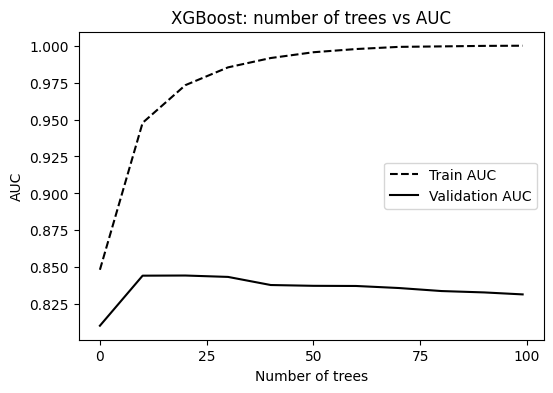

In [171]:
plt.figure(figsize=(6, 4))
plt.plot(tree, aucs_train, color='black', linestyle='dashed', label='Train AUC')
plt.plot(tree, aucs_val, color='black', linestyle='solid', label='Validation AUC')
plt.xticks(range(0, 101, 25))

plt.legend()

plt.title('XGBoost: number of trees vs AUC')
plt.xlabel('Number of trees')
plt.ylabel('AUC')

plt.show()

#### Настройка параметров XGBoost eta=0.3

In [172]:
xgb_params = {
    'eta': 0.3,
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 4,
    'seed': 23
}

In [173]:
%%capture output
model = xgb.train(xgb_params, dtrain, num_boost_round=500, \
                 evals=watchlist, verbose_eval=10)


In [174]:
tree, _, aucs_val_eta_03 = parse_xgb_output(output)
print(max(aucs_val_eta_03))
print(max(zip(aucs_val_eta_03, tree)))

0.84441
(0.84441, 20)


#### Настройка параметров XGBoost eta=0.1

In [175]:
xgb_params = {
    'eta': 0.1,
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 4,
    'seed': 23
}


In [176]:
%%capture output
model = xgb.train(xgb_params, dtrain, num_boost_round=500, \
                 evals=watchlist, verbose_eval=10)

In [177]:
tree, _, aucs_val_eta_01 = parse_xgb_output(output)
print(max(aucs_val_eta_01))
print(max(zip(aucs_val_eta_01, tree)))

0.84968
(0.84968, 40)


#### Настройка параметров XGBoost eta=0.05

In [178]:
xgb_params = {
    'eta': 0.05,
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 4,
    'seed': 23
}


In [179]:
%%capture output
model = xgb.train(xgb_params, dtrain, num_boost_round=500, \
                 evals=watchlist, verbose_eval=10)

In [180]:
tree, _, aucs_val_eta_005 = parse_xgb_output(output)
print(max(aucs_val_eta_005))
print(max(zip(aucs_val_eta_005, tree)))

0.85576
(0.85576, 80)


#### Настройка параметров XGBoost eta=0.01

In [181]:
xgb_params = {
    'eta': 0.01,
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 4,
    'seed': 23
}


In [182]:
%%capture output
model = xgb.train(xgb_params, dtrain, num_boost_round=500, \
                 evals=watchlist, verbose_eval=10)

In [183]:
tree, _, aucs_val_eta_001 = parse_xgb_output(output)
print(max(aucs_val_eta_001))
print(max(zip(aucs_val_eta_001, tree)))

0.85344
(0.85344, 390)


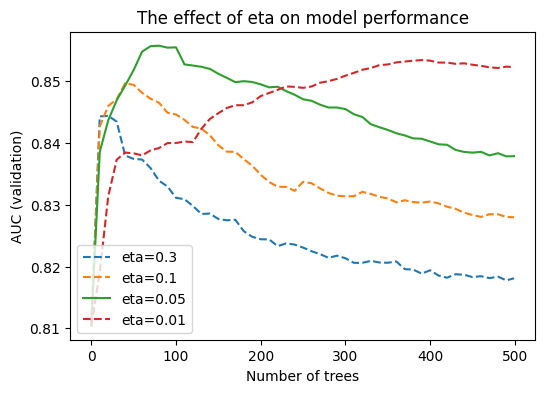

In [184]:
plt.figure(figsize=(6, 4))

plt.plot(tree, aucs_val_eta_03, linestyle='dashed', label='eta=0.3')
plt.plot(tree, aucs_val_eta_01, linestyle='dashed', label='eta=0.1')
plt.plot(tree, aucs_val_eta_005, linestyle='solid', label='eta=0.05')
plt.plot(tree, aucs_val_eta_001, linestyle='dashed', label='eta=0.01')

plt.xticks(range(0, 501, 100))

plt.legend()

plt.title('The effect of eta on model performance')
plt.xlabel('Number of trees')
plt.ylabel('AUC (validation)')

plt.show()

#### Настройка параметров XGBoost max_depth=3

In [185]:
xgb_params = {
    'eta': 0.05,
    'max_depth': 3,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 4,
    'seed': 23
}


In [186]:
%%capture output
model = xgb.train(xgb_params, dtrain, num_boost_round=500, \
                 evals=watchlist, verbose_eval=10)

In [187]:
tree, _, aucs_val_depth3 = parse_xgb_output(output)
print(max(aucs_val_depth3))
print(max(zip(aucs_val_depth3, tree)))

0.85909
(0.85909, 170)


#### Настройка параметров XGBoost max_depth=4

In [189]:
xgb_params = {
    'eta': 0.05,
    'max_depth': 4,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 4,
    'seed': 23
}


In [190]:
%%capture output
model = xgb.train(xgb_params, dtrain, num_boost_round=500, \
                 evals=watchlist, verbose_eval=10)

In [191]:
tree, _, aucs_val_depth4 = parse_xgb_output(output)
print(max(aucs_val_depth4))
print(max(zip(aucs_val_depth4, tree)))

0.8576
(0.8576, 100)


#### Настройка параметров XGBoost max_depth=6

In [192]:
xgb_params = {
    'eta': 0.05,
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 4,
    'seed': 23
}


In [193]:
%%capture output
model = xgb.train(xgb_params, dtrain, num_boost_round=500, \
                 evals=watchlist, verbose_eval=10)

In [194]:
tree, _, aucs_val_depth6 = parse_xgb_output(output)
print(max(aucs_val_depth6))
print(max(zip(aucs_val_depth6, tree)))

0.85576
(0.85576, 80)


#### Настройка параметров XGBoost max_depth=10

In [195]:
xgb_params = {
    'eta': 0.05,
    'max_depth': 10,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 4,
    'seed': 23
}


In [196]:
%%capture output
model = xgb.train(xgb_params, dtrain, num_boost_round=500, \
                 evals=watchlist, verbose_eval=10)

In [197]:
tree, _, aucs_val_depth10 = parse_xgb_output(output)
print(max(aucs_val_depth10))
print(max(zip(aucs_val_depth10, tree)))

0.84649
(0.84649, 70)


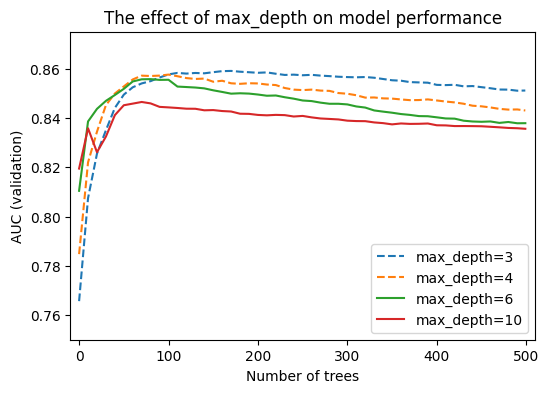

In [198]:
plt.figure(figsize=(6, 4))

plt.plot(tree, aucs_val_depth3, linestyle='dashed', label='max_depth=3')
plt.plot(tree, aucs_val_depth4, linestyle='dashed', label='max_depth=4')
plt.plot(tree, aucs_val_depth6, linestyle='solid', label='max_depth=6')
plt.plot(tree, aucs_val_depth10, linestyle='solid', label='max_depth=10')


plt.ylim(0.75, 0.875)
plt.xlim(-10, 510)
plt.xticks(range(0, 501, 100))

plt.legend()

plt.title('The effect of max_depth on model performance')
plt.xlabel('Number of trees')
plt.ylabel('AUC (validation)')

plt.show()

#### Настройка параметров XGBoost min_child_weight=1

In [199]:
xgb_params = {
    'eta': 0.05,
    'max_depth': 3,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 4,
    'seed': 23
}


In [200]:
%%capture output
model = xgb.train(xgb_params, dtrain, num_boost_round=500, \
                 evals=watchlist, verbose_eval=10)

In [201]:
tree, _, aucs_val_mcw1 = parse_xgb_output(output)
print(max(aucs_val_mcw1))
print(max(zip(aucs_val_mcw1, tree)))

0.85909
(0.85909, 170)


#### Настройка параметров XGBoost min_child_weight=10

In [202]:
xgb_params = {
    'eta': 0.05,
    'max_depth': 3,
    'min_child_weight': 10,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 4,
    'seed': 23
}


In [203]:
%%capture output
model = xgb.train(xgb_params, dtrain, num_boost_round=500, \
                 evals=watchlist, verbose_eval=10)

In [204]:
tree, _, aucs_val_mcw10 = parse_xgb_output(output)
print(max(aucs_val_mcw10))
print(max(zip(aucs_val_mcw10, tree)))

0.86428
(0.86428, 210)


#### Настройка параметров XGBoost min_child_weight=30

In [205]:
xgb_params = {
    'eta': 0.05,
    'max_depth': 3,
    'min_child_weight': 30,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 4,
    'seed': 23
}


In [206]:
%%capture output
model = xgb.train(xgb_params, dtrain, num_boost_round=500, \
                 evals=watchlist, verbose_eval=10)

In [207]:
tree, _, aucs_val_mcw30 = parse_xgb_output(output)
print(max(aucs_val_mcw30))
print(max(zip(aucs_val_mcw30, tree)))

0.86696
(0.86696, 290)


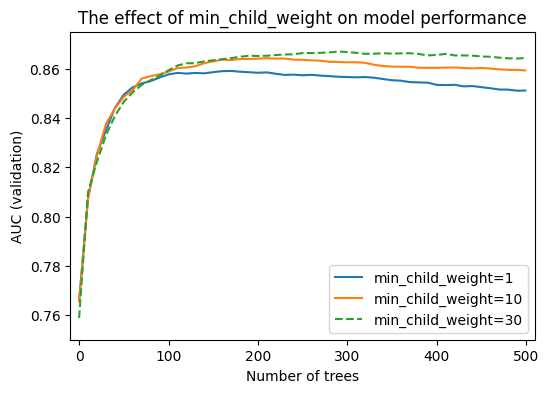

In [208]:
plt.figure(figsize=(6, 4))

plt.plot(tree, aucs_val_mcw1, linestyle='solid', label='min_child_weight=1')
plt.plot(tree, aucs_val_mcw10, linestyle='solid', label='min_child_weight=10')
plt.plot(tree, aucs_val_mcw30, linestyle='dashed', label='min_child_weight=30')


plt.ylim(0.75, 0.875)
plt.xlim(-10, 510)
plt.xticks(range(0, 501, 100))

plt.legend()

plt.title('The effect of min_child_weight on model performance')
plt.xlabel('Number of trees')
plt.ylabel('AUC (validation)')

plt.show()

#### Параметры окончательной модели:

In [231]:
xgb_params = {
    'eta': 0.05,
    'max_depth': 3,
    'min_child_weight': 30,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 4,
    'seed': 23
}


#### Обучим окончательную модель Градиентного бустинга

In [232]:
%%capture output
model = xgb.train(xgb_params, dtrain, num_boost_round=500, \
                 evals=watchlist, verbose_eval=10)

In [233]:
tree, _, aucs_val_final = parse_xgb_output(output)
print(max(aucs_val_final))
print(max(zip(aucs_val_final, tree)))

0.86696
(0.86696, 290)


In [234]:
y_pred_xgb = model.predict(dval)
auc = roc_auc_score(y_val, y_pred_xgb)
print('%.3f' % auc)

0.864


#### Приведём вместе лучшие результаты AUC на проверочных данных для Дерева решений, Случайного леса и Градиентного бустинга:

In [244]:
print(roc_auc_score(y_val, y_pred_dt))
print(roc_auc_score(y_val, y_pred_rf))
print(roc_auc_score(y_val, y_pred_xgb))

0.49956198399193297
0.5018150879183211
0.5129829205268797


# 6. Результаты на тестовой выборке

#### Протестируем выбранную модель градиентного бустинга на тестовом наборе

In [240]:
xgb_params = {
    'eta': 0.05,
    'max_depth': 3,
    'min_child_weight': 30,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 4,
    'seed': 23
}

xgb_final = xgb.train(xgb_params, dtrain, num_boost_round=500)

#### XGBoost

In [241]:
y_pred_xgb = xgb_final.predict(dtest)
print(roc_auc_score(y_test, y_pred_xgb))

0.8420407682337693


#### Random Forest

In [242]:
y_pred_rf = rf.predict_proba(X_test)[:, 1]
roc_auc_score(y_test, y_pred_rf)

0.8375338753387535

#### Decision Tree

In [243]:
y_pred_dt = dt.predict_proba(X_test)[:, 1]
roc_auc_score(y_test, y_pred_dt)

0.7894603511252504